In [ ]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torchvision import models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import skimage
from skimage import color
from random import shuffle
from sklearn import preprocessing
from IPython.display import clear_output
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

skimage.__version__

'0.14.2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data

In [ ]:
!unzip -q '/content/drive/MyDrive/Data/data.zip' 

In [ ]:
f = open('/content/drive/MyDrive/Data/data.json')
labels = json.load(f)

In [ ]:
labels.keys()

dict_keys(['initial_bundle', 'test_bundle'])

In [ ]:
train_labels = labels['initial_bundle']
test_labels = labels['test_bundle']

len(train_labels), len(test_labels)

(1558, 1545)

In [ ]:
def get_dataframe(labels):
    df = pd.DataFrame(columns=['path', 'label', 'size'])
    for i in range(len(labels)):
        if labels[i]['category'] is not None:
            if labels[i]['category']['name'] == 'Plants':
                df.loc[len(df.index), ['path', 'label']] = ['/content/' + labels[i]['file'], 'plants']        
            elif labels[i]['category']['name'] == 'Vehicles':
                df.loc[len(df.index), ['path', 'label']] = ['/content/' + labels[i]['file'], 'vehicle']
            else:
                df.loc[len(df.index), ['path', 'label']] = ['/content/' + labels[i]['file'], 'other']
        else:
            df.loc[len(df.index), ['path', 'label']] = ['/content/' + labels[i]['file'], 'other']
        img = Image.open(labels[i]['file'])
        img.load()
        df.loc[len(df.index)-1, 'size'] = np.array(img).shape
    return df

In [ ]:
train_data = get_dataframe(train_labels)
test_data_full = get_dataframe(test_labels)

In [ ]:
valid_data, test_data = train_test_split(test_data_full, test_size=0.5, random_state=8)

In [ ]:
train_data['size'].value_counts()

(360, 360, 4)    605
(360, 360, 3)    334
(320, 640, 4)    199
(360, 640, 3)     71
(282, 640, 4)     64
                ... 
(16, 640, 4)       1
(18, 640, 4)       1
(360, 541, 3)      1
(240, 640, 3)      1
(360, 475, 4)      1
Name: size, Length: 97, dtype: int64

In [ ]:
encoder = preprocessing.LabelEncoder()

In [ ]:
train_data['numlabel'] = encoder.fit_transform(train_data['label'])
valid_data['numlabel'] = encoder.fit_transform(valid_data['label'])
test_data['numlabel'] = encoder.fit_transform(test_data['label'])
test_data_full['numlabel'] = encoder.fit_transform(test_data_full['label'])

In [ ]:
test_data.sample(5)

,path,label,size,numlabel
722,/content/data/e79d526d-0fc6-4ab1-85e9-add5af9e...,other,"(320, 640, 4)",0
427,/content/data/1214dd35-1197-40b3-969b-c71e2657...,other,"(320, 640, 4)",0
1084,/content/data/aa766ded-78ee-488d-8eff-68d5b7ca...,vehicle,"(360, 360, 4)",2
611,/content/data/be1dacb3-e156-4b05-a192-91ad1e87...,other,"(360, 530, 3)",0
207,/content/data/fb4f3ec9-ab38-459f-a10a-fdf533e8...,other,"(360, 360, 4)",0


In [ ]:
class ImagesDataset(Dataset):
    def __init__(self, df: pd.DataFrame, size: tuple):
        super().__init__()
        self.df = df
        self.len_ = len(self.df)
        self.size = size
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def transform(self, img):
          img = np.array(img)
          if img.shape[-1] == 4:
              img = color.rgba2rgb(img)
          elif len(img.shape) == 2:
              img = color.gray2rgb(img)
          img = skimage.transform.resize(img, self.size)
          img = img.transpose(2, 0, 1)
          img = torch.tensor(img, dtype=torch.float32)
          return img

    
    def __getitem__(self, index):
        img = self.load_sample(self.df.loc[index, 'path'])
        label = self.df.loc[index, 'numlabel']
        img = self.transform(img)
        return img, label 

In [ ]:
def get_dataloader(dataset, data, size, batch_size, shuffle):
    data_set = dataset(data, size)
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=shuffle, drop_last=False)
    return data_loader

In [ ]:
train_loader = get_dataloader(ImagesDataset, train_data, batch_size=16, size=(360, 360), shuffle=True)
valid_loader = get_dataloader(ImagesDataset, valid_data.reset_index(), batch_size=16, size=(360, 360), shuffle=True)
test_loader  = get_dataloader(ImagesDataset, test_data.reset_index(),  batch_size=16, size=(360, 360), shuffle=True)

### Training loop

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train(model, opt, scheduler, criterion, train_loader, valid_loader, epochs, device, start_idx):
  model = model.to(DEVICE)
  history = {'train loss by epoch': [],
             'valid loss by epoch': [],
             'train loss by batch': [],
             'valid loss by batch': []}

  iters = len(train_loader)

  log_template = "Epoch {ep:d}:\t mean train_loss: {t_loss:0.6f}\t mean val_loss {v_loss:0.6f}\n"

  for i, epoch in enumerate(range(epochs)):
      model.train()
        
      train_loss_per_epoch = []
      val_loss_per_epoch = []

      for x, y in tqdm(train_loader):
          opt.zero_grad()
          x, y = x.to(DEVICE), y.to(DEVICE)
          logits = model(x)
          loss = criterion(logits, y)
          train_loss_per_epoch.append(loss.item())

          loss.backward()
          opt.step()
            
          if scheduler is not None:
            scheduler.step(epoch + i / iters)  

      history['train loss by epoch'].append(np.mean(train_loss_per_epoch))
      history['train loss by batch'].extend(train_loss_per_epoch)

      model.eval()
      with torch.no_grad():
          for x, y in valid_loader:
              x, y = x.to(DEVICE), y.to(DEVICE)
              logits = model(x)
              loss = criterion(logits, y)
              val_loss_per_epoch.append(loss.item())
            
          curr_loss_val = np.mean(val_loss_per_epoch)
          history['valid loss by epoch'].append(curr_loss_val)
          history['valid loss by batch'].extend(val_loss_per_epoch)
      
      clear_output(True)
      fig, axs = plt.subplots(1, 2, figsize=(20, 5))
  
      axs[0].plot(history['train loss by batch'])
      axs[0].set_title("Train loss")
      axs[0].set_xlabel("Batch")
      axs[0].set_ylabel("Loss")
  
      axs[1].plot(history['valid loss by batch'])
      axs[1].set_title("Valid loss")
      axs[1].set_xlabel("Batch")
      axs[1].set_ylabel("Loss")
      plt.show()
    
      tqdm.write(log_template.format(ep=start_idx+epoch+1, t_loss=np.mean(train_loss_per_epoch),
                                     v_loss=curr_loss_val))
      
  return history, model

### Fine-tuned densenet

In [ ]:
densenet = models.densenet121(pretrained=True)

In [ ]:
layers_to_unfreeze = 4
for param in densenet.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False 
densenet.classifier = nn.Linear(1024, 3)

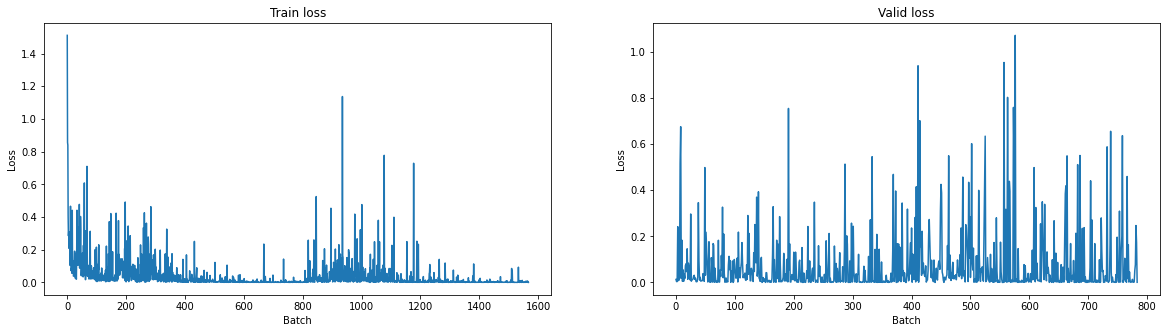

Epoch 16:	 mean train_loss: 0.005158	 mean val_loss 0.079665



In [ ]:
model = densenet
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=8, T_mult=1, eta_min=5e-6)

history, model = train(model=model,
                       opt=optimizer,
                       scheduler=lr_scheduler,
                       criterion=nn.CrossEntropyLoss(),
                       train_loader=train_loader,
                       valid_loader=valid_loader,
                       epochs=16,
                       start_idx=0)

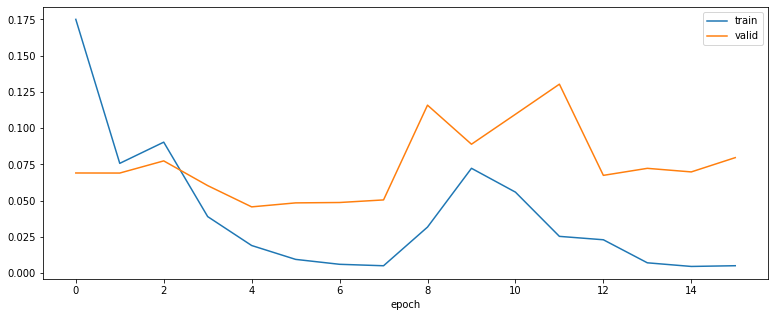

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(history['train loss by epoch'], label='train')
plt.plot(history['valid loss by epoch'], label='valid')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
def get_classification_report(model, test_dataframe):
    y_true = list(test_dataframe['numlabel'])
    y_preds = list(test_dataframe['predicted'])
    report = classification_report(y_true, y_preds, labels=list(set(y_true)), output_dict=True)
    for clss in report.keys():
        print(clss)
        print(report[clss])
        print()

In [ ]:
def evaluate(model, test_dataframe, device):
    test_dataframe['predicted'] = None
    test_dataframe['probability'] = None

    test_dataset = ImagesDataset(test_dataframe, (360, 360))

    for i in tqdm(range(len(test_dataframe))):
        img = Image.open(test_dataframe.loc[i, 'path'])
        img.load()
        img = test_dataset.transform(img).unsqueeze(0).to(DEVICE)
        res = model(img)
        y_hat = res.softmax(dim=1).argmax(dim=1) 
        proba = torch.max(res.softmax(dim=1))
        test_dataframe.loc[i, 'predicted'] = y_hat.item()
        test_dataframe.loc[i, 'probability'] = proba.item()
    return test_dataframe



In [ ]:
test_data_full = evaluate(model, test_data_full, 'cuda')
test_data_full

  0%|          | 0/1545 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 1545/1545 [02:01<00:00, 12.71it/s]


,path,label,size,numlabel,predicted,probability
0,/content/data/7e5ba16b-6223-41f3-8f64-07ea079e...,plants,"(360, 360, 4)",1,1,0.99494
1,/content/data/ef6e4cfe-c96a-4cd1-b30c-0e966dc4...,other,"(360, 360, 4)",0,0,0.997837
2,/content/data/386d835c-bc56-4d6d-bb45-98741b3a...,other,"(282, 640, 4)",0,0,0.999992
3,/content/data/25db6f12-b897-41e8-a6ed-e2a3c83f...,other,"(320, 640, 4)",0,0,0.999435
4,/content/data/c83b3205-ec7c-4847-ba23-92348c22...,other,"(360, 360, 3)",0,0,0.999994
...,...,...,...,...,...,...
1540,/content/data/11b73379-55c5-4940-b597-34c85e92...,other,"(360, 181, 4)",0,0,0.999999
1541,/content/data/5d390191-44d7-4848-9821-4528a278...,other,"(320, 640, 4)",0,0,0.999988
1542,/content/data/59897e41-0abe-4dd7-aad0-fdd85c2a...,other,"(360, 360, 3)",0,0,0.998836
1543,/content/data/21d5bd2f-13e7-40f3-9063-2414722b...,other,"(360, 360, 3)",0,0,0.999915


In [ ]:
get_classification_report(model, test_data_full)

0
{'precision': 0.9895498392282959, 'recall': 0.9863782051282052, 'f1-score': 0.9879614767255217, 'support': 1248}

1
{'precision': 0.9173553719008265, 'recall': 0.9652173913043478, 'f1-score': 0.940677966101695, 'support': 115}

2
{'precision': 0.9611111111111111, 'recall': 0.9505494505494505, 'f1-score': 0.9558011049723757, 'support': 182}

accuracy
0.9805825242718447

macro avg
{'precision': 0.9560054407467445, 'recall': 0.9673816823273343, 'f1-score': 0.9614801825998641, 'support': 1545}

weighted avg
{'precision': 0.9808260772477219, 'recall': 0.9805825242718447, 'f1-score': 0.9806535211392352, 'support': 1545}



In [ ]:
test_loader_full  = get_dataloader(ImagesDataset, test_data_full,  batch_size=32, size=(360, 360), shuffle=False)

[Text(39.5, 0.5, 'True'), Text(0.5, 39.5, 'Pred')]

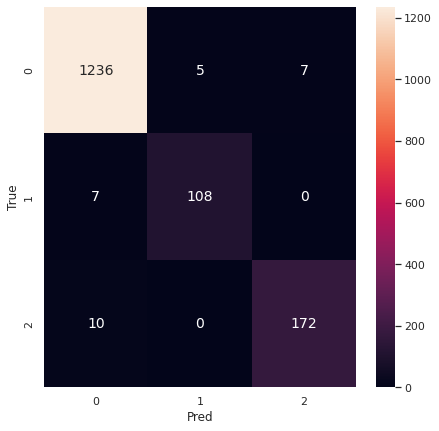

In [ ]:
cf_matrix = confusion_matrix(y_true=y_true,
                             y_pred=y_preds,
                             labels=list(set(y_true)))

sns.set(rc={'figure.figsize':(7, 7)})
s = sns.heatmap(cf_matrix, annot=True, annot_kws={"fontsize":14}, fmt='d',
           xticklabels=list(set(y_true)), yticklabels=list(set(y_true)))
s.set(xlabel='Pred', ylabel='True')

In [ ]:
test_data_full['predicted'] = None
test_data_full['probability'] = None

In [ ]:
test_dataset = ImagesDataset(test_data_full, (360, 360))

for i in range(len(test_data_full)):
    img = Image.open(test_data_full.loc[i, 'path'])
    img.load()
    img = np.array(img)
    img = test_dataset.transform(img).unsqueeze(0).to(DEVICE)
    res = model(img)
    y_hat = res.softmax(dim=1).argmax(dim=1) 
    proba = torch.max(res.softmax(dim=1))
    test_data_full.loc[i, 'predicted'] = y_hat.item()
    test_data_full.loc[i, 'probability'] = proba.item()

In [ ]:
test_data_full

,path,label,size,numlabel,predicted,probability
0,/content/data/7e5ba16b-6223-41f3-8f64-07ea079e...,plants,"(360, 360, 4)",1,1,0.985433
1,/content/data/ef6e4cfe-c96a-4cd1-b30c-0e966dc4...,other,"(360, 360, 4)",0,0,0.999954
2,/content/data/386d835c-bc56-4d6d-bb45-98741b3a...,other,"(282, 640, 4)",0,0,1.0
3,/content/data/25db6f12-b897-41e8-a6ed-e2a3c83f...,other,"(320, 640, 4)",0,0,0.999972
4,/content/data/c83b3205-ec7c-4847-ba23-92348c22...,other,"(360, 360, 3)",0,0,1.0
...,...,...,...,...,...,...
1540,/content/data/11b73379-55c5-4940-b597-34c85e92...,other,"(360, 181, 4)",0,0,1.0
1541,/content/data/5d390191-44d7-4848-9821-4528a278...,other,"(320, 640, 4)",0,0,0.99999
1542,/content/data/59897e41-0abe-4dd7-aad0-fdd85c2a...,other,"(360, 360, 3)",0,0,0.999945
1543,/content/data/21d5bd2f-13e7-40f3-9063-2414722b...,other,"(360, 360, 3)",0,0,0.999991


In [ ]:
rslt_df = test_data_full[test_data_full['numlabel'] != test_data_full['predicted']]

In [ ]:
rslt_df

,path,label,size,numlabel,predicted,probability
5,/content/data/d062fd1b-b3f5-4bf1-ad8f-71f327c4...,other,"(282, 640, 4)",0,2,0.980248
71,/content/data/906a18ff-4486-45eb-8c4f-e67258d6...,vehicle,"(360, 360, 4)",2,0,0.999956
78,/content/data/8c1a5dac-235e-4bd9-a532-8ecd32c7...,other,"(360, 360, 4)",0,1,0.555304
204,/content/data/00c8fdc8-44d7-4334-863a-3ba76412...,other,"(360, 360, 4)",0,2,0.666237
219,/content/data/cc30a7ee-a338-4041-8463-26c4bbe4...,vehicle,"(360, 640, 4)",2,0,0.992497
264,/content/data/4150ccab-997d-437c-9b6b-2c2b92f4...,vehicle,"(360, 360, 4)",2,0,0.999848
317,/content/data/862ad233-7f3d-4181-8963-54f28927...,plants,"(360, 360, 4)",1,0,0.513101
444,/content/data/54868e09-71a4-46fd-817f-cbce0c70...,other,"(360, 360, 4)",0,2,0.907997
463,/content/data/8c388542-6851-4bce-9ffd-aa7a6b42...,other,"(360, 360, 4)",0,2,0.760421
488,/content/data/97dc811e-b540-4169-bfb7-e15d08bb...,other,"(360, 360, 4)",0,2,0.955469


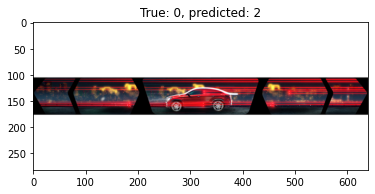

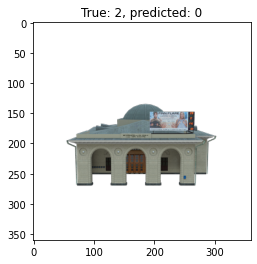

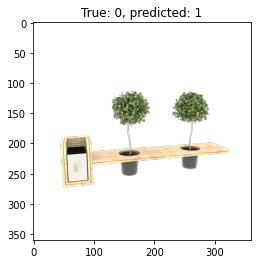

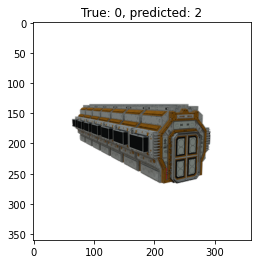

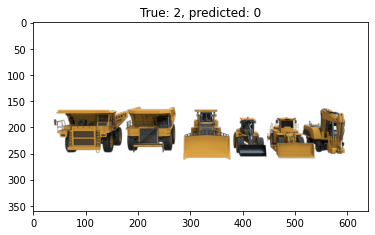

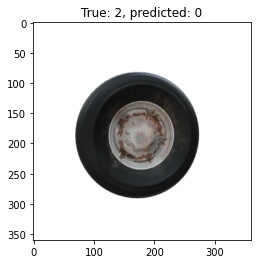

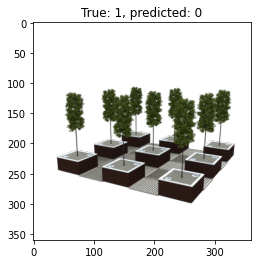

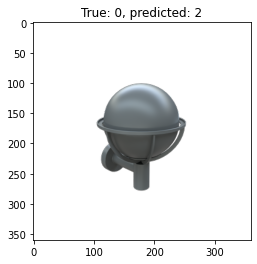

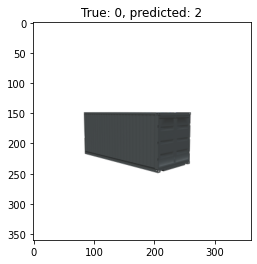

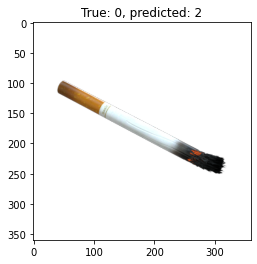

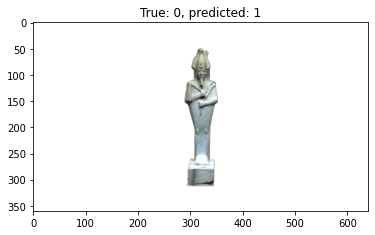

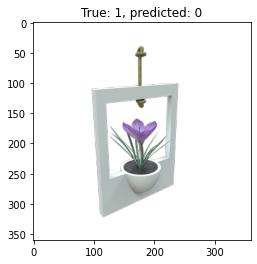

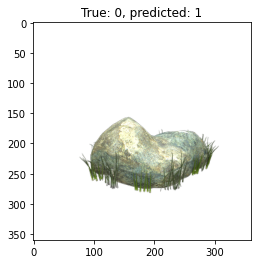

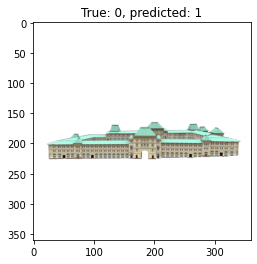

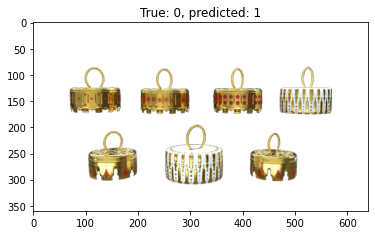

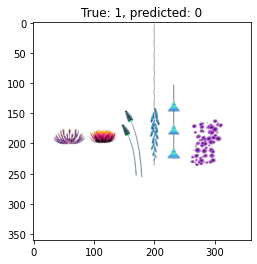

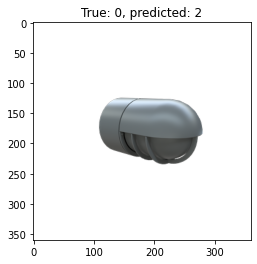

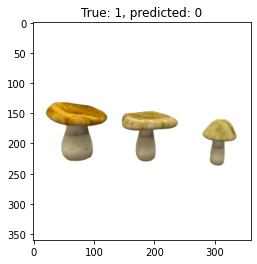

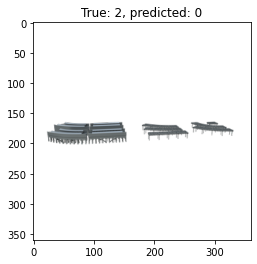

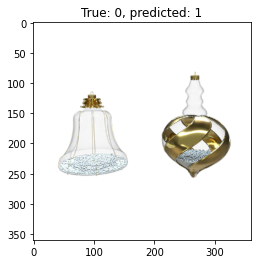

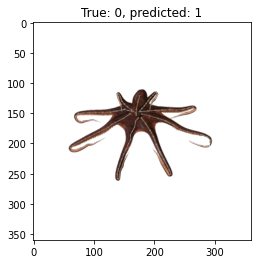

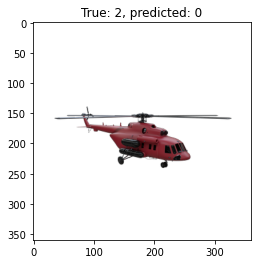

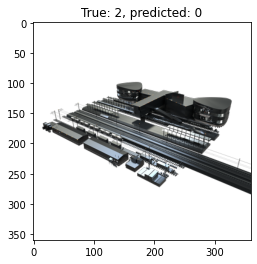

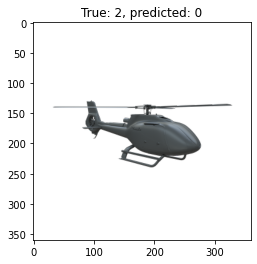

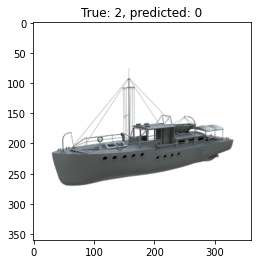

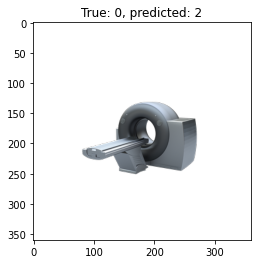

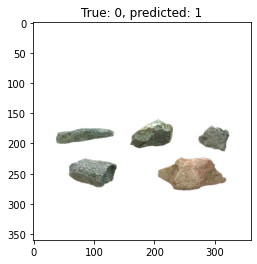

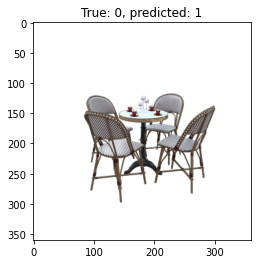

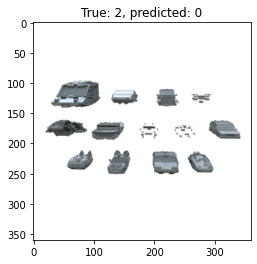

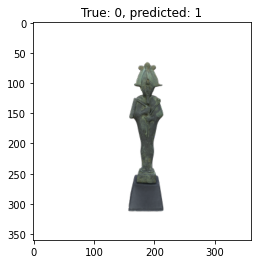

In [ ]:
for i in rslt_df.index:
    # print(i)
    img = Image.open(rslt_df.loc[i, 'path'])
    img.load()
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"True: {rslt_df.loc[i, 'numlabel']}, predicted: {rslt_df.loc[i, 'predicted']}")
    plt.show()